# A rough look in personal investment strategies in US Equities

In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd

### Example data retrieval

In [7]:
ticker = yf.Ticker("VOO")
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
hist_df = ticker.history(period="5y")
hist_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-06-08,173.85,173.98,172.81,172.89,1130100,0.0,0
2015-06-09,172.88,173.38,172.22,172.84,1466100,0.0,0
2015-06-10,173.66,175.30,173.58,174.90,1247700,0.0,0
2015-06-11,175.46,175.84,175.17,175.44,724700,0.0,0
2015-06-12,174.61,174.80,173.88,174.15,2147700,0.0,0


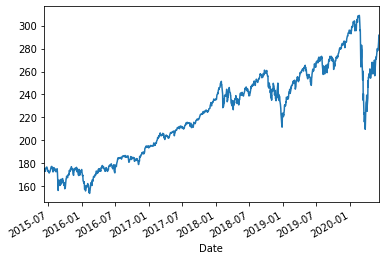

In [8]:
hist_df['Open'].plot()

In [12]:
ticker.dividends.head()

Date
2015-06-22    0.902
2015-09-21    0.953
2015-12-21    1.092
2016-03-21    1.006
2016-06-21    0.953
Name: Dividends, dtype: float64

### Simple dollar cost averaging

This tries to answer the question: had we bought only SP500 / world stock index / certain sectors using DCA everyday / first day of month / middle of the month in the last specified number of years, what the return would have looked like.


In [153]:
# Setup
# SP500, Russell 2000, total stock market, REIT, Amazon, Google, Microsoft, Apple
ticker_names = ['VOO', 'VTWO', 'VTSMX', 'VNQ', 'AMZN', 'GOOGL', 'MSFT', 'AAPL']
tickers = [yf.Ticker(t) for t in ticker_names]

period = 'max'

In [154]:
data_df = [t.history(period=period) for t in tickers]
first_date_all_available = max([df.iloc[0].name for df in data_df])
print("first date where all tickers have data: {}".format(first_date_all_available))

first date where all tickers have data: 2010-09-22 00:00:00


In [155]:
from functools import reduce
data_df_suffix = [data_df[i].add_suffix(ticker_names[i]) for i in range(len(ticker_names))]
merged_df = pd.concat(data_df_suffix, axis=1, join='inner')
merged_df.head()

,OpenVOO,HighVOO,LowVOO,CloseVOO,VolumeVOO,DividendsVOO,Stock SplitsVOO,OpenVTWO,HighVTWO,LowVTWO,...,VolumeMSFT,DividendsMSFT,Stock SplitsMSFT,OpenAAPL,HighAAPL,LowAAPL,CloseAAPL,VolumeAAPL,DividendsAAPL,Stock SplitsAAPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-22,85.80,86.20,85.31,85.47,18100,0.000,0.0,46.74,46.76,45.97,...,94299400,0.0,0.0,34.96,35.61,34.93,35.59,146322400,0.0,0.0
2010-09-23,84.79,85.62,84.62,84.77,33300,0.000,0.0,45.58,46.31,45.40,...,46201800,0.0,0.0,35.41,36.21,35.37,35.73,196529200,0.0,0.0
2010-09-24,85.76,86.55,85.69,86.50,24100,0.558,0.0,46.20,46.93,46.13,...,51948800,0.0,0.0,36.12,36.30,35.93,36.15,162372000,0.0,0.0
2010-09-27,86.62,86.62,86.09,86.09,15000,0.000,0.0,47.32,47.32,46.70,...,43603300,0.0,0.0,36.36,36.45,35.99,36.01,120708700,0.0,0.0
2010-09-28,86.07,86.65,85.33,86.65,49800,0.000,0.0,46.41,47.43,46.25,...,56041200,0.0,0.0,36.08,36.08,34.01,35.48,258760600,0.0,0.0


In [156]:
# Start date
import dateutil

first_date = dateutil.parser.parse("2018-01-04")
last_date = dateutil.parser.parse("2020-06-05")

daily_notional = 200

In [165]:
# daily DCA, dividends are not reinvested
# (to immediately reinvest dividends, do we have to apply a continuous loop as opposed to row operations?)
# and to fairly account for dividends, REIT is taxed at a different rate than others (?)

data_df_filtered = [d[(d.index >= first_date) & (d.index <= last_date)] for d in data_df]

for i in range(len(data_df_filtered)):
    data_df_filtered[i].loc[:, 'add_shares'] = daily_notional / data_df_filtered[i]['Open']
    data_df_filtered[i].loc[:, 'add_shares_cumsum'] = data_df_filtered[i]['add_shares'].cumsum()
    data_df_filtered[i].loc[:, 'add_dividends'] = data_df_filtered[i]['add_shares_cumsum'] * data_df_filtered[i]['Dividends']

total_shares = {ticker_names[i]: {
    "total_add_shares": data_df_filtered[i]['add_shares'].sum(),
    "total_dividends": data_df_filtered[i]['add_dividends'].sum(),
    "first_opening_price": data_df_filtered[i].iloc[-1]["Open"],
    "last_closing_price": data_df_filtered[i].iloc[-1]["Close"],
    "trading_days": len(data_df_filtered[i].index),
    "total_investment_notional": daily_notional * len(data_df_filtered[i].index),
} for i in range(len(ticker_names))}

summary_df = pd.DataFrame.from_dict(total_shares).transpose()

summary_df['total_end_notional'] = summary_df['total_add_shares'] * summary_df['last_closing_price']
summary_df['total_end_value'] = summary_df['total_dividends'] + summary_df['total_end_notional']
summary_df['total_return'] = summary_df['total_end_value'] / summary_df['total_investment_notional']
summary_df

,total_add_shares,total_dividends,first_opening_price,last_closing_price,trading_days,total_investment_notional,total_end_notional,total_end_value,total_return
VOO,477.542983,2913.255568,291.63,293.61,609.0,121800.0,140211.395304,143124.650872,1.175079
VTWO,1012.532460,1781.583443,121.70,120.86,609.0,121800.0,122374.673057,124156.256500,1.019345
VTSMX,1760.387086,2605.821877,78.81,78.81,609.0,121800.0,138736.106271,141341.928148,1.160443
VNQ,1538.758187,5780.738814,84.49,84.69,609.0,121800.0,130317.430894,136098.169709,1.117391
AMZN,69.358596,0.000000,2444.51,2483.00,609.0,121800.0,172217.392914,172217.392914,1.413936
GOOGL,103.357461,0.000000,1415.64,1440.02,609.0,121800.0,148836.810869,148836.810869,1.221977
MSFT,1035.352155,2840.677242,182.62,187.20,609.0,121800.0,193817.923472,196658.600714,1.614603
AAPL,600.003069,2534.479931,323.35,331.50,609.0,121800.0,198901.017497,201435.497428,1.653822
